# Build Models
## Goal
- Initial model is based on LeNet5
- Will replace AveragePooling2D with MaxPooling2D and add BatchNormalization, which allows the model to converge much faster in training
- Will add Dropout layers between convolutional layers and dense layers

## Conclusion
- For the final model, will start with LeNet5
- Replace AveragePooling2D after convolutional layers with MaxPooling2D and BatchNormalization
- Drop 50% of the input units before every dense layer
- Replace ReLU activation functions with LeakyReLU


In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Modeling Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import sys
sys.path.append('../../src')
import functions as fx

In [2]:
train_path = '../../chest_xray/train'
test_path = '../../chest_xray/new_test'
val_path = '../../chest_xray/new_val'
# Include data augmentation with training data, and 
train_generator = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 30, zoom_range = [0.9, 1.0],
                                    width_shift_range = 0.1, height_shift_range = 0.1,
                                    horizontal_flip = True) \
    .flow_from_directory(train_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')
val_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(val_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [3]:
# Calculate weights to balance normal and pneumonia data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

In [4]:
# Stop training if val_loss does not decrease at least 0.01 in 5 epochs
early_stop_loss = EarlyStopping(monitor = 'val_loss', 
                                min_delta = 0.01, patience = 5, 
                                mode = 'min', restore_best_weights = True)
# Some of the models predicted all images were pneumonia
# and consistently resulted in val_accuracy=0.6034 and val_recall=1
# To break this loop, stop training if val_accuracy does not increase at least 0.01 in 5 epochs
early_stop_acc = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.01, patience = 5, 
                               mode = 'max', restore_best_weights = True)

## Models
### First Model:  LeNet5 replacing AveragePooling2D with MaxPooling2D and add BatchNormalization

In [5]:
def trial_1(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(82, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [6]:
model_1 = trial_1(train_generator[0][0][0])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 6)       456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 6)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 6)       24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 16)      2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 16)        64        
_________________________________________________________________
flatten (Flatten)            (None, 59536)             0

In [7]:
result_1 = model_1.fit(train_generator, epochs = 20, validation_data=val_generator, 
                       class_weight = train_class_weights, 
                       callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 118s 1s/step - loss: 0.4895 - accuracy: 0.8572 - recall: 0.8545 - val_loss: 4.3673 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 110s 1s/step - loss: 0.2889 - accuracy: 0.8890 - recall: 0.8836 - val_loss: 4.9317 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 111s 1s/step - loss: 0.2307 - accuracy: 0.9151 - recall: 0.9099 - val_loss: 5.6092 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 111s 1s/step - loss: 0.2174 - accuracy: 0.9201 - recall: 0.9146 - val_loss: 4.4549 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 5/20
82/82 [==============================] - 111s 1s/step - loss: 0.2350 - accuracy: 0.9137 - recall: 0.9076 - val_loss: 3.9156 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 6/20
82/82 [==============================] - 111s 1s/step - loss: 0.2151 - accuracy: 0.9216 - reca

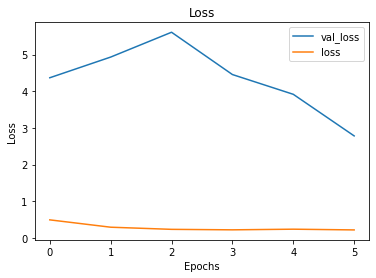

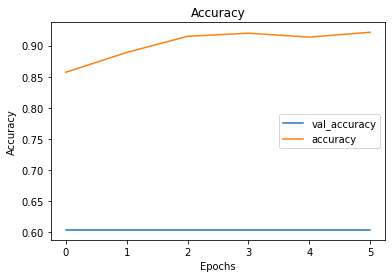

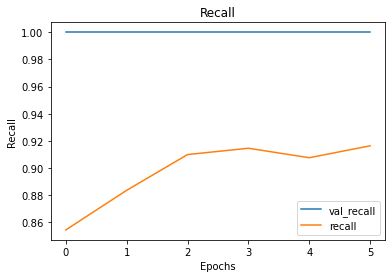

In [8]:
fx.visualize_training_results(result_1)

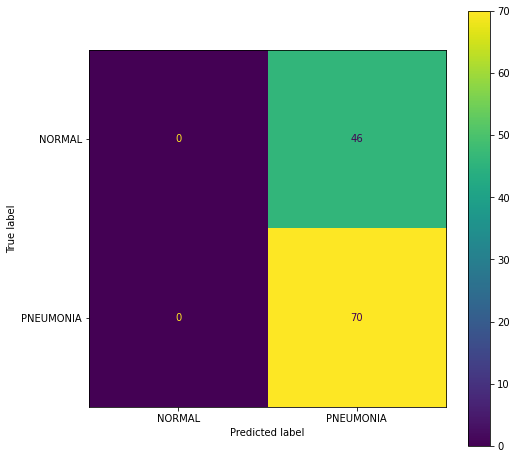

In [9]:
fx.create_confusion_matrix(model_1, val_generator)

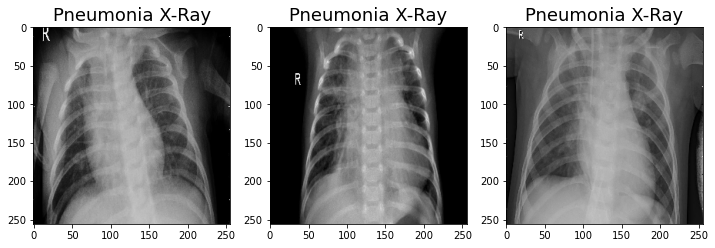

In [10]:
fx.display_lime(model_1, val_generator)

### Second Model: Add Dropout between Dense Layers

In [11]:
def trial_2(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(120, activation='relu'),
        Dropout(0.5),
        Dense(82, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [12]:
model_2 = trial_2(train_generator[0][0][0])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 252, 252, 6)       456       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 6)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 126, 126, 6)       24        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 16)      2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 61, 61, 16)        64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 59536)            

In [13]:
result_2 = model_2.fit(train_generator, epochs = 20, validation_data=val_generator, 
                       class_weight = train_class_weights, 
                       callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 112s 1s/step - loss: 1.2309 - accuracy: 0.7508 - recall: 0.7535 - val_loss: 1.3939 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 112s 1s/step - loss: 0.5537 - accuracy: 0.7897 - recall: 0.7737 - val_loss: 3.5111 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 111s 1s/step - loss: 0.5392 - accuracy: 0.7655 - recall: 0.7265 - val_loss: 1.1279 - val_accuracy: 0.6293 - val_recall: 0.9857
Epoch 4/20
82/82 [==============================] - 112s 1s/step - loss: 0.4507 - accuracy: 0.7836 - recall: 0.7345 - val_loss: 5.3361 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 5/20
82/82 [==============================] - 113s 1s/step - loss: 0.3998 - accuracy: 0.8244 - recall: 0.7907 - val_loss: 2.0309 - val_accuracy: 0.6121 - val_recall: 0.9857
Epoch 6/20
82/82 [==============================] - 112s 1s/step - loss: 0.3869 - accuracy: 0.8135 - reca

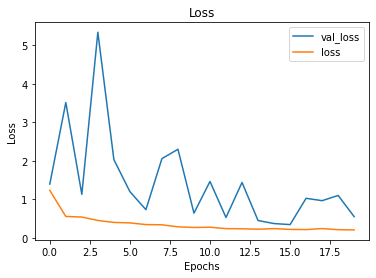

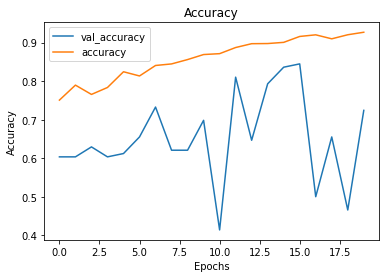

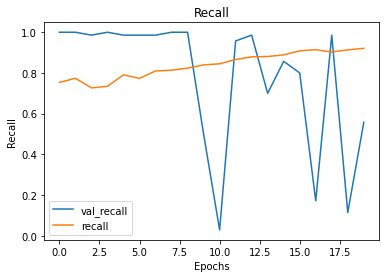

In [14]:
fx.visualize_training_results(result_2)

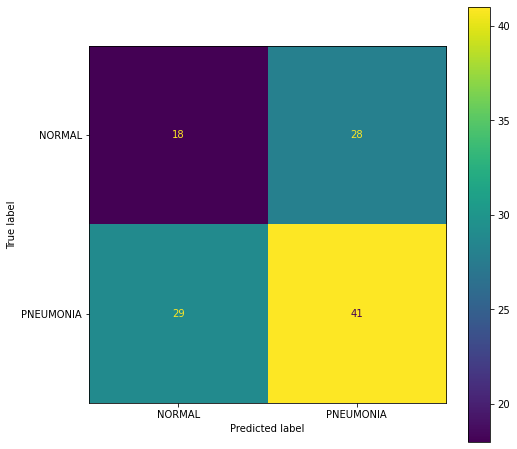

In [15]:
fx.create_confusion_matrix(model_2, val_generator)

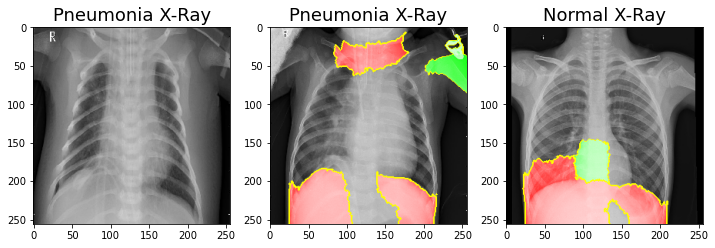

In [16]:
fx.display_lime(model_2, val_generator)

### Third Model: Add Dropout between Convolutional Layers

In [17]:
def trial_3(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.5),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(120, activation='relu'),
        Dropout(0.5),
        Dense(82, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [18]:
model_3 = trial_3(train_generator[0][0][0])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 252, 252, 6)       456       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 6)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 6)       24        
_________________________________________________________________
dropout_3 (Dropout)          (None, 126, 126, 6)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 122, 122, 16)      2416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 16)       

In [19]:
result_3 = model_3.fit(train_generator, epochs = 20, validation_data=val_generator, 
                       class_weight = train_class_weights, 
                       callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 121s 1s/step - loss: 1.0443 - accuracy: 0.7604 - recall: 0.7726 - val_loss: 5.2444 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 119s 1s/step - loss: 0.5149 - accuracy: 0.8206 - recall: 0.8142 - val_loss: 4.4230 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 117s 1s/step - loss: 0.4000 - accuracy: 0.8173 - recall: 0.7951 - val_loss: 2.9458 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 117s 1s/step - loss: 0.3550 - accuracy: 0.8439 - recall: 0.8165 - val_loss: 1.7775 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 5/20
82/82 [==============================] - 117s 1s/step - loss: 0.3828 - accuracy: 0.8223 - recall: 0.7925 - val_loss: 2.1984 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 6/20
82/82 [==============================] - 117s 1s/step - loss: 0.3799 - accuracy: 0.8315 - reca

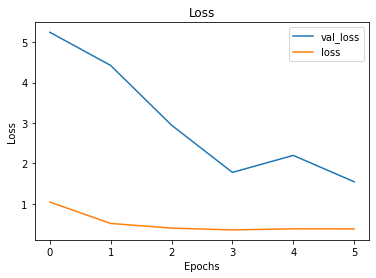

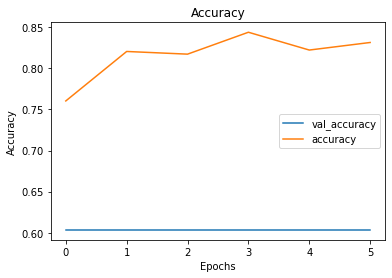

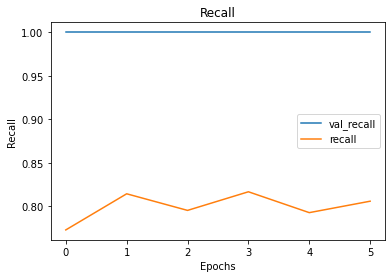

In [20]:
fx.visualize_training_results(result_3)

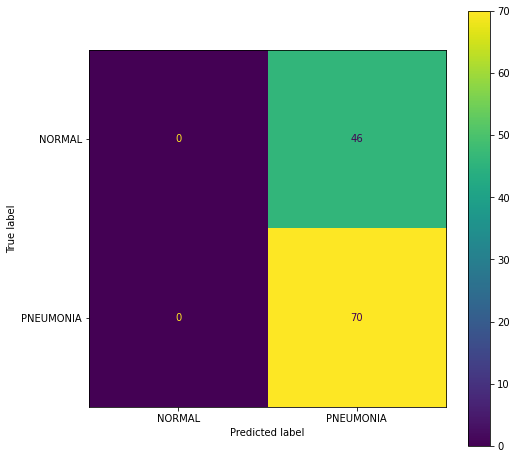

In [21]:
fx.create_confusion_matrix(model_3, val_generator)

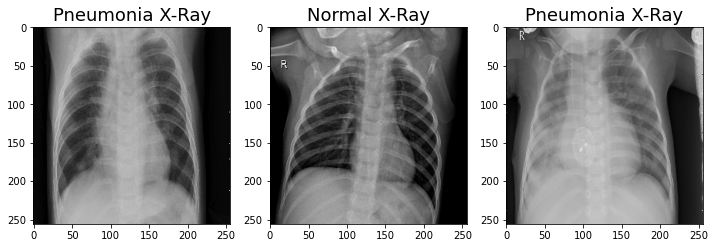

In [22]:
fx.display_lime(model_3, val_generator)

### Fourth Model: Remove Dropout between Convolutional Layers, decrease kernel size to 3*3

In [23]:
def trial_4(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (3, 3), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(120, activation='relu'),
        Dropout(0.5),
        Dense(82, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [24]:
model_4 = trial_4(train_generator[0][0][0])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 6)       168       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 6)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 127, 127, 6)       24        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 16)      880       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 16)        64        
_________________________________________________________________
flatten_3 (Flatten)          (None, 61504)            

In [25]:
result_4 = model_4.fit(train_generator, epochs = 20, validation_data=val_generator, 
                       class_weight = train_class_weights, 
                       callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 113s 1s/step - loss: 0.9695 - accuracy: 0.8144 - recall: 0.8212 - val_loss: 1.1378 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 114s 1s/step - loss: 0.4833 - accuracy: 0.8315 - recall: 0.8183 - val_loss: 1.4089 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 115s 1s/step - loss: 0.4372 - accuracy: 0.8468 - recall: 0.8317 - val_loss: 1.4513 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 115s 1s/step - loss: 0.4298 - accuracy: 0.8336 - recall: 0.8054 - val_loss: 0.5729 - val_accuracy: 0.6724 - val_recall: 0.9857
Epoch 5/20
82/82 [==============================] - 115s 1s/step - loss: 0.4051 - accuracy: 0.8265 - recall: 0.7930 - val_loss: 1.1385 - val_accuracy: 0.6293 - val_recall: 1.0000
Epoch 6/20
82/82 [==============================] - 115s 1s/step - loss: 0.3304 - accuracy: 0.8353 - reca

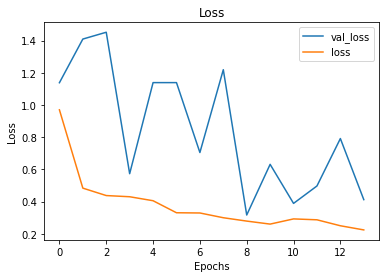

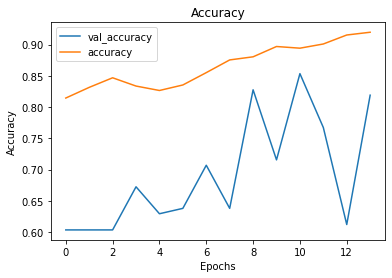

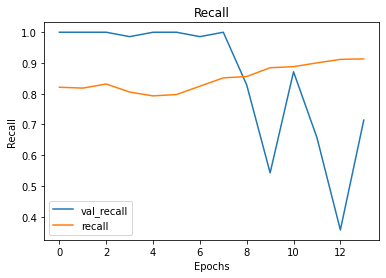

In [26]:
fx.visualize_training_results(result_4)

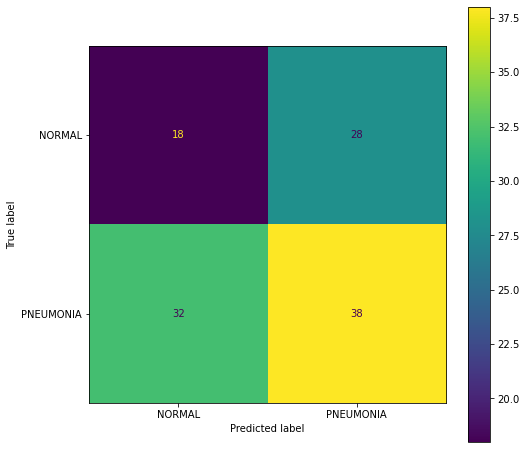

In [27]:
fx.create_confusion_matrix(model_4, val_generator)

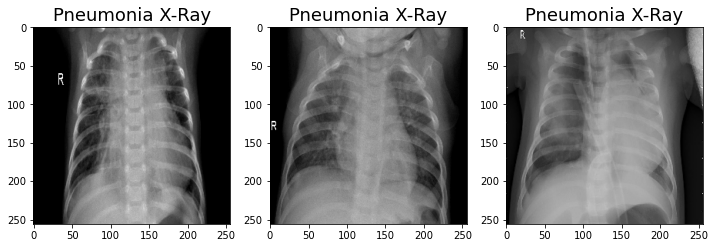

In [28]:
fx.display_lime(model_4, val_generator)

### Note:
- All models appear to be stuck predicting pneumonia
- There may be a "dying relu" problem that may be causing this issue
- I will try reruning the above models using a "leaky relu" to see if this solves the problem

In [29]:
from tensorflow.keras.layers import LeakyReLU

## LeakyReLU Models
### Fifth Model: LeNet5 replacing AveragePooling2D with MaxPooling2D and add BatchNormalization

In [30]:
def trial_5(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(16, (5, 5), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(120, activation = LeakyReLU()),
        Dense(82, activation = LeakyReLU()),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [31]:
model_5 = trial_5(train_generator[0][0][0])
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 252, 252, 6)       456       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 126, 126, 6)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 6)       24        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 122, 122, 16)      2416      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 61, 61, 16)        64        
_________________________________________________________________
flatten_4 (Flatten)          (None, 59536)            

In [32]:
result_5 = model_5.fit(train_generator, epochs = 20, validation_data=val_generator, 
                       class_weight = train_class_weights, 
                       callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 123s 2s/step - loss: 0.8643 - accuracy: 0.8512 - recall: 0.8524 - val_loss: 6.2344 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 123s 1s/step - loss: 0.4583 - accuracy: 0.8848 - recall: 0.8834 - val_loss: 5.2692 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 122s 1s/step - loss: 0.3603 - accuracy: 0.9022 - recall: 0.9009 - val_loss: 0.7290 - val_accuracy: 0.7155 - val_recall: 0.7286
Epoch 4/20
82/82 [==============================] - 122s 1s/step - loss: 0.3707 - accuracy: 0.9015 - recall: 0.9006 - val_loss: 0.7753 - val_accuracy: 0.7672 - val_recall: 0.8714
Epoch 5/20
82/82 [==============================] - 123s 2s/step - loss: 0.2452 - accuracy: 0.9218 - recall: 0.9174 - val_loss: 3.4396 - val_accuracy: 0.6121 - val_recall: 1.0000
Epoch 6/20
82/82 [==============================] - 123s 1s/step - loss: 0.2453 - accuracy: 0.9212 - reca

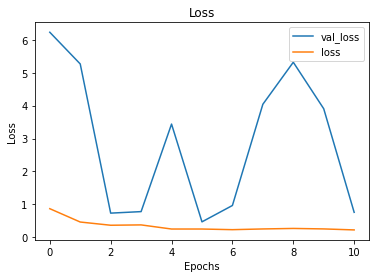

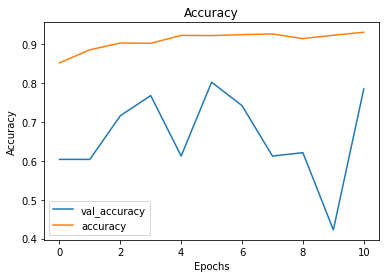

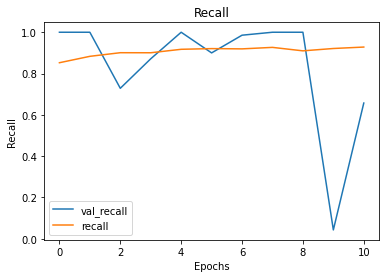

In [33]:
fx.visualize_training_results(result_5)

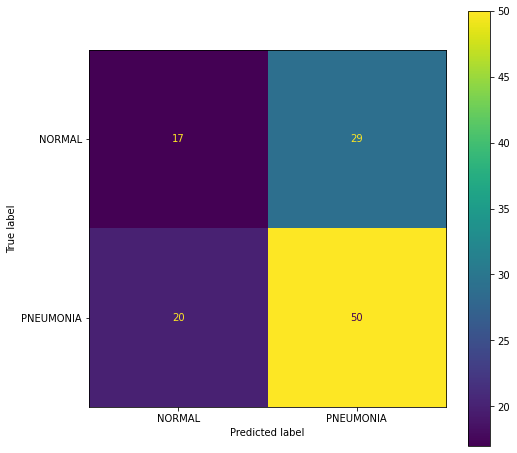

In [34]:
fx.create_confusion_matrix(model_5, val_generator)

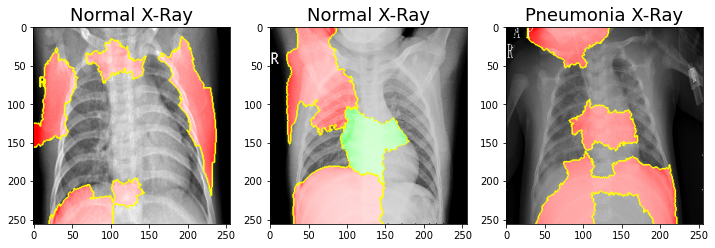

In [35]:
fx.display_lime(model_5, val_generator)

### Sixth Model: Add Dropout between Dense Layers

In [39]:
def trial_6(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(16, (5, 5), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(120, activation = LeakyReLU()),
        Dropout(0.5),
        Dense(82, activation = LeakyReLU()),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [40]:
model_6 = trial_6(train_generator[0][0][0])
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 252, 252, 6)       456       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 126, 126, 6)       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 6)       24        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 122, 122, 16)      2416      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 61, 61, 16)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 16)        64        
_________________________________________________________________
flatten_6 (Flatten)          (None, 59536)            

In [41]:
result_6 = model_6.fit(train_generator, epochs = 20, validation_data=val_generator, 
                       class_weight = train_class_weights, 
                       callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 126s 2s/step - loss: 1.9521 - accuracy: 0.7939 - recall: 0.7969 - val_loss: 3.6401 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 125s 2s/step - loss: 1.2277 - accuracy: 0.8445 - recall: 0.8454 - val_loss: 5.9110 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 124s 2s/step - loss: 1.0930 - accuracy: 0.8480 - recall: 0.8514 - val_loss: 11.4918 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 124s 2s/step - loss: 0.8551 - accuracy: 0.8589 - recall: 0.8568 - val_loss: 8.2362 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 5/20
82/82 [==============================] - 123s 2s/step - loss: 0.7055 - accuracy: 0.8669 - recall: 0.8666 - val_loss: 8.0436 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 6/20
82/82 [==============================] - 124s 2s/step - loss: 0.6021 - accuracy: 0.8671 - rec

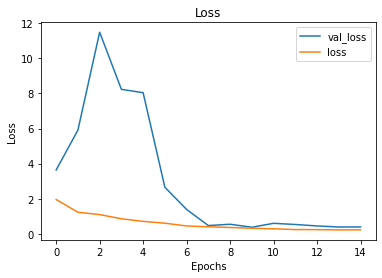

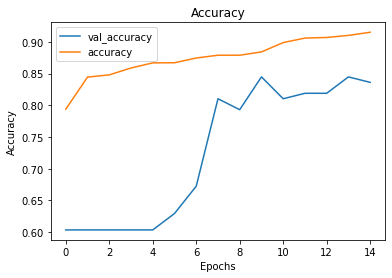

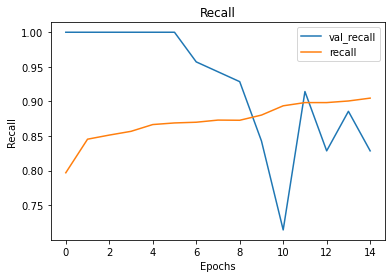

In [42]:
fx.visualize_training_results(result_6)

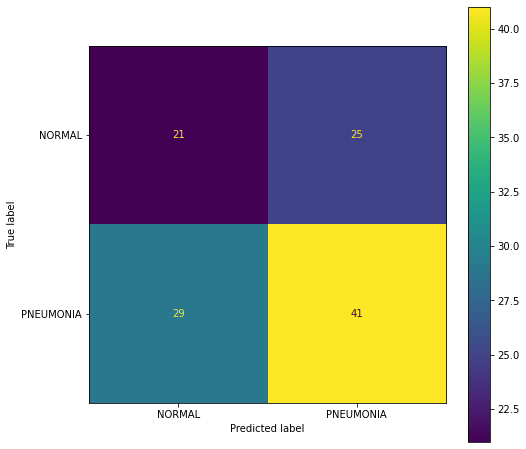

In [43]:
fx.create_confusion_matrix(model_6, val_generator)

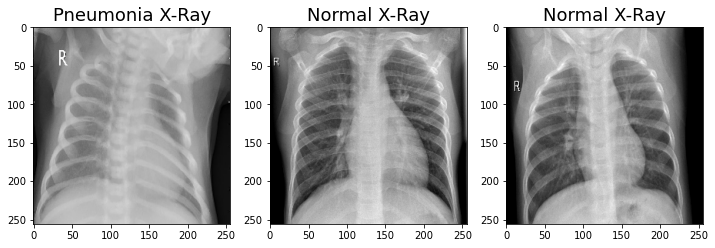

In [44]:
fx.display_lime(model_6, val_generator)

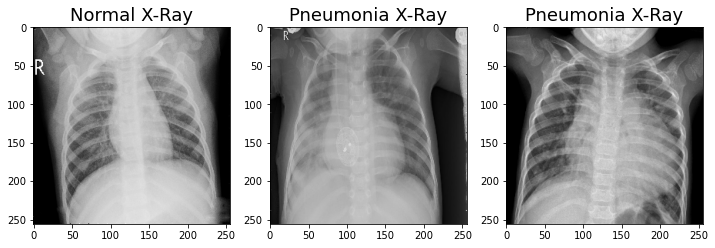

In [45]:
fx.display_lime(model_6, val_generator)

### Seventh Model: Add Dropout between Convolutional Layers

In [46]:
def trial_7(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.5),
        Conv2D(16, (5, 5), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(120, activation = LeakyReLU()),
        Dropout(0.5),
        Dense(82, activation = LeakyReLU()),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [47]:
model_7 = trial_7(train_generator[0][0][0])
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 252, 252, 6)       456       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 126, 126, 6)       0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 126, 126, 6)       24        
_________________________________________________________________
dropout_16 (Dropout)         (None, 126, 126, 6)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 122, 122, 16)      2416      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 61, 61, 16)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 61, 61, 16)       

In [48]:
result_7 = model_7.fit(train_generator, epochs = 20, validation_data=val_generator, 
                       class_weight = train_class_weights, 
                       callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 124s 2s/step - loss: 1.6509 - accuracy: 0.7983 - recall: 0.7990 - val_loss: 1.8932 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 126s 2s/step - loss: 1.0568 - accuracy: 0.8386 - recall: 0.8387 - val_loss: 5.2547 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 124s 2s/step - loss: 0.8187 - accuracy: 0.8589 - recall: 0.8573 - val_loss: 3.5422 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 124s 2s/step - loss: 0.7991 - accuracy: 0.8520 - recall: 0.8526 - val_loss: 0.4655 - val_accuracy: 0.8534 - val_recall: 0.8143
Epoch 5/20
82/82 [==============================] - 125s 2s/step - loss: 0.6609 - accuracy: 0.8610 - recall: 0.8643 - val_loss: 2.5553 - val_accuracy: 0.5000 - val_recall: 0.1714
Epoch 6/20
82/82 [==============================] - 124s 2s/step - loss: 0.5401 - accuracy: 0.8666 - reca

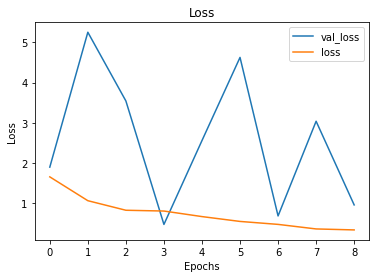

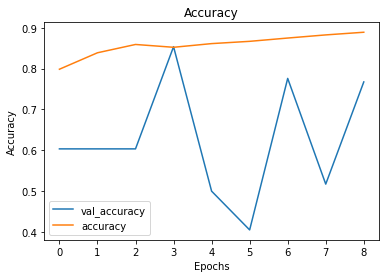

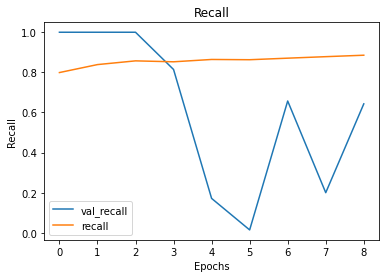

In [49]:
fx.visualize_training_results(result_7)

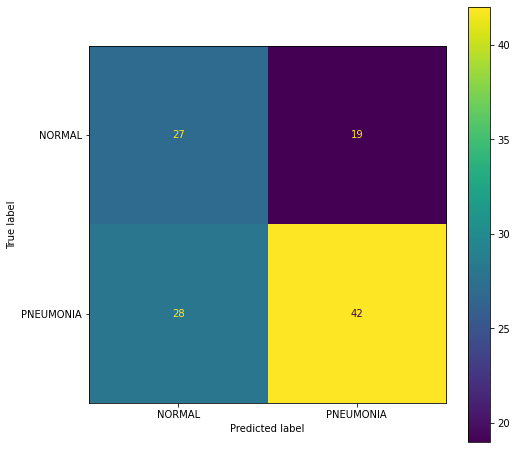

In [50]:
fx.create_confusion_matrix(model_7, val_generator)

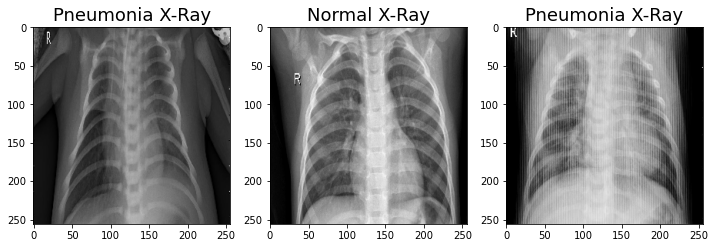

In [51]:
fx.display_lime(model_7, val_generator)

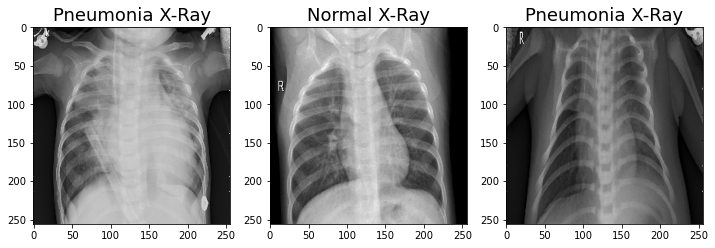

In [52]:
fx.display_lime(model_7, val_generator)

### Eighth Model: Remove Dropout between Convolutional Layers, decrease kernel size to 3*3

In [53]:
def trial_8(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (3, 3), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(16, (3, 3), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(120, activation = LeakyReLU()),
        Dropout(0.5),
        Dense(82, activation = LeakyReLU()),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [54]:
model_8 = trial_8(train_generator[0][0][0])
model_8.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 254, 254, 6)       168       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 127, 127, 6)       0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 127, 127, 6)       24        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 125, 16)      880       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 62, 62, 16)        64        
_________________________________________________________________
flatten_8 (Flatten)          (None, 61504)            

In [55]:
result_8 = model_8.fit(train_generator, epochs = 20, validation_data=val_generator, 
                       class_weight = train_class_weights, 
                       callbacks = [early_stop_loss, early_stop_acc])

Epoch 1/20
82/82 [==============================] - 117s 1s/step - loss: 2.1964 - accuracy: 0.7870 - recall: 0.7910 - val_loss: 3.5110 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 116s 1s/step - loss: 1.0341 - accuracy: 0.8572 - recall: 0.8594 - val_loss: 10.2815 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 117s 1s/step - loss: 0.9363 - accuracy: 0.8683 - recall: 0.8697 - val_loss: 9.5602 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 117s 1s/step - loss: 0.7584 - accuracy: 0.8823 - recall: 0.8852 - val_loss: 8.1094 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 5/20
82/82 [==============================] - 116s 1s/step - loss: 0.5979 - accuracy: 0.8834 - recall: 0.8831 - val_loss: 4.7729 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 6/20
82/82 [==============================] - 115s 1s/step - loss: 0.5034 - accuracy: 0.8842 - rec

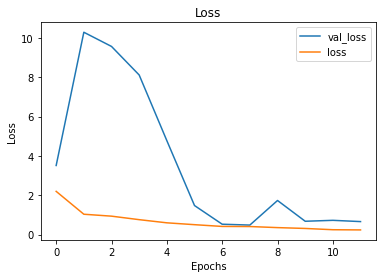

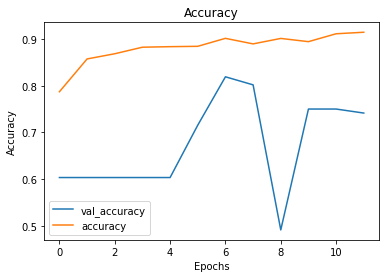

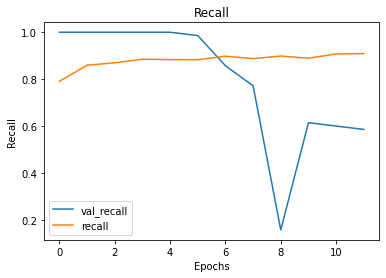

In [56]:
fx.visualize_training_results(result_8)

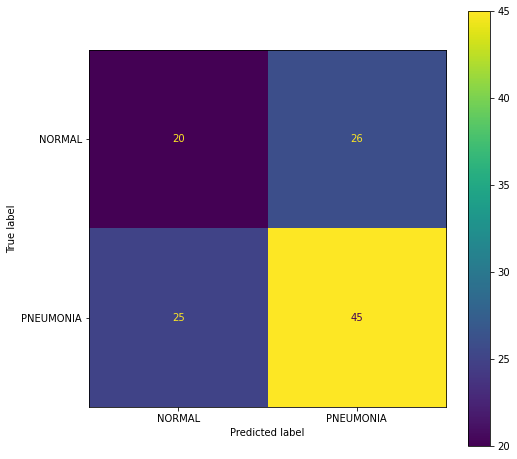

In [57]:
fx.create_confusion_matrix(model_8, val_generator)

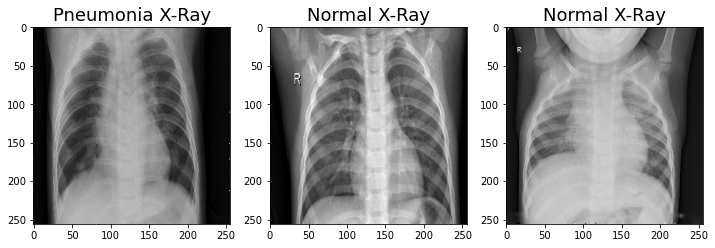

In [58]:
fx.display_lime(model_8, val_generator)

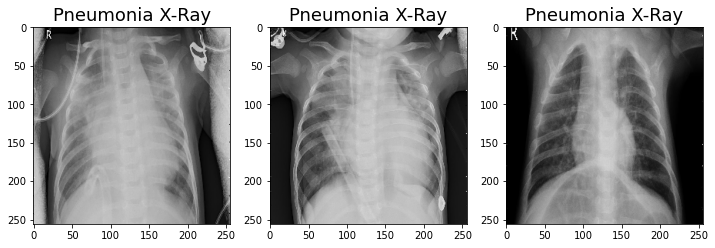

In [59]:
fx.display_lime(model_8, val_generator)

## Conclusion
- The sixth model appears to perform the best based on the loss function and the accuracy